In [17]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping
from keras.layers import Bidirectional
from keras.optimizers import Adam, RMSprop, Nadam
from sklearn.model_selection import GridSearchCV
import requests
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='keras.optimizers.optimizer_v2.adam')

In [18]:
def fetch_data(ticker, interval):
    url = f'https://api.coingecko.com/api/v3/coins/{ticker}/ohlc?vs_currency=usd&days=30&interval={interval}h'
    response = requests.get(url)
    json_data = response.json()
    
    data = pd.DataFrame(json_data, columns=['timestamp', 'open', 'high', 'low', 'close'])
    data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
    data.set_index('timestamp', inplace=True)
    return data

In [19]:
def normalize_data(data):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data['close'].values.reshape(-1, 1))
    return scaled_data, scaler

In [20]:
def split_data(scaled_data):
    train_size = int(len(scaled_data) * 0.8)
    test_size = len(scaled_data) - train_size
    train, test = scaled_data[0:train_size, :], scaled_data[train_size:len(scaled_data), :]
    return train, test

In [21]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [22]:
def find_best_lookback(train, test, lookback_values, scaler):
    lowest_test_rmse = float('inf')
    best_look_back = 1
    test_rmse_values = []

    for look_back in lookback_values:
        train_X, train_y = create_dataset(train, look_back)
        test_X, test_y = create_dataset(test, look_back)

        train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
        test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

        model, history = build_and_train_model(train_X, train_y, test_X, test_y, look_back)
        trainPredict, testPredict = model.predict(train_X), model.predict(test_X)

        train_rmse = np.sqrt(mean_squared_error(scaler.inverse_transform(train_y.reshape(-1, 1)), scaler.inverse_transform(trainPredict)))
        test_rmse = round(np.sqrt(mean_squared_error(scaler.inverse_transform(test_y.reshape(-1, 1)), scaler.inverse_transform(testPredict))), 2)

        print(f"Lookback value {look_back}: Test RMSE = {test_rmse:.2f}")
        test_rmse_values.append(test_rmse)

        if test_rmse < lowest_test_rmse:
            lowest_test_rmse = test_rmse
            best_look_back = look_back

    return best_look_back, test_rmse_values

In [23]:
def build_and_train_model(train_X, train_y, test_X, test_y, look_back=1, dropout_rate=0.2, learning_rate=0.001, optimizer='adam', bidirectional=False):
    model = Sequential()

    if bidirectional:
        model.add(Bidirectional(LSTM(64, input_shape=(look_back, 1), return_sequences=True)))
    else:
        model.add(LSTM(64, input_shape=(look_back, 1), return_sequences=True))

    model.add(Dropout(dropout_rate))
    model.add(LSTM(32, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))

    if optimizer == 'adam':
        opt = Adam(lr=learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(lr=learning_rate)
    elif optimizer == 'nadam':
        opt = Nadam(lr=learning_rate)

    model.compile(loss='mean_squared_error', optimizer=opt)
    early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=0)
    history = model.fit(train_X, train_y, epochs=100, batch_size=1, verbose=0, validation_data=(test_X, test_y), callbacks=[early_stop])
    return model, history

In [24]:
def calculate_rmse(train_y, test_y, trainPredict, testPredict, scaler):
    train_rmse = np.sqrt(mean_squared_error(scaler.inverse_transform(train_y.reshape(-1, 1)), scaler.inverse_transform(trainPredict)))
    test_rmse = np.sqrt(mean_squared_error(scaler.inverse_transform(test_y.reshape(-1, 1)), scaler.inverse_transform(testPredict)))

    return train_rmse, test_rmse

In [25]:
def calculate_intervals(trainPredict, testPredict, train_data, scaler, look_back):
    residuals = train_data[look_back:-1, 0] - trainPredict[:, 0]
    std_dev = np.std(residuals)

    upper_bound1 = testPredict + (0.43 * std_dev)
    lower_bound1 = testPredict - (0.43 * std_dev)

    upper_bound2 = testPredict + (0.675 * std_dev)
    lower_bound2 = testPredict - (0.675 * std_dev)

    upper_bound1 = scaler.inverse_transform(upper_bound1)
    lower_bound1 = scaler.inverse_transform(lower_bound1)

    upper_bound2 = scaler.inverse_transform(upper_bound2)
    lower_bound2 = scaler.inverse_transform(lower_bound2)

    return (upper_bound1, lower_bound1), (upper_bound2, lower_bound2)

In [26]:
def predict_future_prices(models, data, look_back, n_future):
    input_data = np.array(data[-look_back:])
    input_data = np.reshape(input_data, (1, input_data.shape[0], 1))
    future_prices = []
    
    for _ in range(n_future):
        predictions = np.array([model.predict(input_data) for model in models])
        prediction = np.mean(predictions)
        future_prices.append(prediction)

        # Update input_data with the new prediction
        input_data = np.append(input_data[:, 1:, :], prediction)
        input_data = np.reshape(input_data, (1, input_data.shape[0], 1))
    
    return future_prices

In [27]:
def plot_future_prices(data, future_dates, future_prices, bounds1, bounds2, interval):

    upper_bound1, lower_bound1 = bounds1
    upper_bound2, lower_bound2 = bounds2

    print("High and Low values for both confidence intervals:")
    for i, (date, upper1, lower1, upper2, lower2) in enumerate(zip(future_dates, upper_bound1, lower_bound1, upper_bound2, lower_bound2)):
        print(f"Prediction {i + 1} ({date.strftime('%m-%d %H:%M')}):")
        print(f"  33% Confidence Interval: High = {upper1[0]:.2f}, Low = {lower1[0]:.2f}")
        print(f"  50% Confidence Interval: High = {upper2[0]:.2f}, Low = {lower2[0]:.2f}")
    
    fig, ax = plt.subplots(figsize=(12, 6))
    price_data = data.reset_index()
    dates = price_data['timestamp']
    ax.plot(dates[-15:], data['close'][-15:], label='Actual Close Prices', color='blue')

    # Plot the high and low prices
    ax.fill_between(dates[-15:], data['high'][-15:], data['low'][-15:], color='lightblue', label='Actual High-Low Prices')

    future_dates_series = future_dates.to_series()

    for i, (date, price, upper1, lower1, upper2, lower2) in enumerate(zip(future_dates_series, future_prices, upper_bound1, lower_bound1, upper_bound2, lower_bound2)):
        if i == 0:
            label = f"Predicted {i + 1}: {price[0]:.2f} ({date.strftime('%m-%d %H:%M')})"
            ax.plot([dates.iloc[-1], date], [data.iloc[-1]['close'], price[0]], color='red', label=label)
        else:
            label = f"Predicted {i + 1}: {price[0]:.2f} ({date.strftime('%m-%d %H:%M')})"
            ax.plot([future_dates_series[i-1], date], [future_prices[i-1][0], price[0]], color='red', marker='o', label=label)

        yerr1 = (upper1[0] - lower1[0]) / 2
        yerr2 = (upper2[0] - lower2[0]) / 2

        ax.errorbar(date, price[0], yerr=yerr1, color='purple', capsize=3, alpha=0.6, label='33% Confidence Interval' if i == 0 else None)
        ax.errorbar(date, price[0], yerr=yerr2, color='green', capsize=3, alpha=0.8, label='50% Confidence Interval' if i == 0 else None)

    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    ax.set_title('Cryptocurrency Price Prediction with LSTM')
    ax.legend(loc='upper left')

    ax.xaxis.set_major_locator(MaxNLocator(nbins=10))  # You can change the number of bins based on your preference
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
    plt.xticks(rotation=45)

    plt.grid(axis='y')
    plt.show()

In [28]:
def main(ticker, lookback_values, n_future, interval):
    data = fetch_data(ticker, interval)
    scaled_data, scaler = normalize_data(data)
    train, test = split_data(scaled_data)
    best_look_back, test_rmse_values = find_best_lookback(train, test, lookback_values, scaler)
    print(f"Best look back value: {best_look_back}")

    train_X, train_y = create_dataset(train, best_look_back)
    test_X, test_y = create_dataset(test, best_look_back)
    train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
    test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

    # Loop through different combinations of parameters and store the models with their respective validation losses
    dropout_rates = [0.1, 0.2, 0.3]
    learning_rates = [0.001, 0.01, 0.1]
    optimizers = ['adam', 'rmsprop', 'nadam']
    bidirectional_options = [True, False]

    models = []
    val_losses = []

    for dr in dropout_rates:
        for lr in learning_rates:
            for opt in optimizers:
                for bidir in bidirectional_options:
                    model, history = build_and_train_model(train_X, train_y, test_X, test_y, best_look_back, dr, lr, opt, bidir)
                    val_loss = history.history['val_loss'][-1]
                    models.append(model)
                    val_losses.append(val_loss)
                    print(f"Model (dropout_rate={dr}, learning_rate={lr}, optimizer={opt}, bidirectional={bidir}): Val Loss = {val_loss:.5f}")

    # Find the best model based on the lowest validation loss
    best_model_idx = np.argmin(val_losses)
    best_model = models[best_model_idx]
    print(f"Best model: {best_model_idx} (Val Loss = {val_losses[best_model_idx]:.5f})")

    # Plot the training history of the best model
    #plot_training_history(history, title=f'Training and Validation Loss for Lookback = {best_look_back}')

    trainPredict, testPredict = best_model.predict(train_X), best_model.predict(test_X)
    train_rmse, test_rmse = calculate_rmse(train_y, test_y, trainPredict, testPredict, scaler)
    print(f"Train RMSE: {train_rmse:.2f}")
    print(f"Test RMSE: {test_rmse:.2f}")

    upper_bound, lower_bound = calculate_intervals(trainPredict, testPredict, train, scaler, best_look_back)

    future_dates = pd.date_range(start=data.index[-1], periods=n_future + 1, closed='right', freq=f'{interval}h')
    future_prices = predict_future_prices([best_model], scaled_data, best_look_back, n_future)
    future_prices = scaler.inverse_transform(np.array(future_prices).reshape(-1, 1))

    plot_future_prices(data, future_dates, future_prices, upper_bound, lower_bound, interval)

Enter the cryptocurrency ticker (e.g., 'bitcoin' or 'ethereum'):  ethereum
Enter the desired interval (1 for 1 hour, 4 for 4 hours, or 24 for 1 day):  4


2/2 [==============================] - 0s 6ms/step
Lookback value 1: Test RMSE = 22.02
2/2 [==============================] - 0s 5ms/step
Lookback value 2: Test RMSE = 24.09
Best look back value: 1
Model (dropout_rate=0.1, learning_rate=0.001, optimizer=adam, bidirectional=True): Val Loss = 0.00501
Model (dropout_rate=0.1, learning_rate=0.001, optimizer=adam, bidirectional=False): Val Loss = 0.00395


/opt/conda/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model (dropout_rate=0.1, learning_rate=0.001, optimizer=rmsprop, bidirectional=True): Val Loss = 0.00400
Model (dropout_rate=0.1, learning_rate=0.001, optimizer=rmsprop, bidirectional=False): Val Loss = 0.00397


/opt/conda/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/nadam.py:89: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model (dropout_rate=0.1, learning_rate=0.001, optimizer=nadam, bidirectional=True): Val Loss = 0.00404
Model (dropout_rate=0.1, learning_rate=0.001, optimizer=nadam, bidirectional=False): Val Loss = 0.00434
Model (dropout_rate=0.1, learning_rate=0.01, optimizer=adam, bidirectional=True): Val Loss = 0.00451
Model (dropout_rate=0.1, learning_rate=0.01, optimizer=adam, bidirectional=False): Val Loss = 0.00405
Model (dropout_rate=0.1, learning_rate=0.01, optimizer=rmsprop, bidirectional=True): Val Loss = 0.00651
Model (dropout_rate=0.1, learning_rate=0.01, optimizer=rmsprop, bidirectional=False): Val Loss = 0.00454
Model (dropout_rate=0.1, learning_rate=0.01, optimizer=nadam, bidirectional=True): Val Loss = 0.00554
Model (dropout_rate=0.1, learning_rate=0.01, optimizer=nadam, bidirectional=False): Val Loss = 0.00415
Model (dropout_rate=0.1, learning_rate=0.1, optimizer=adam, bidirectional=True): Val Loss = 0.00551
Model (dropout_rate=0.1, learning_rate=0.1, optimizer=adam, bidirectional=Fa

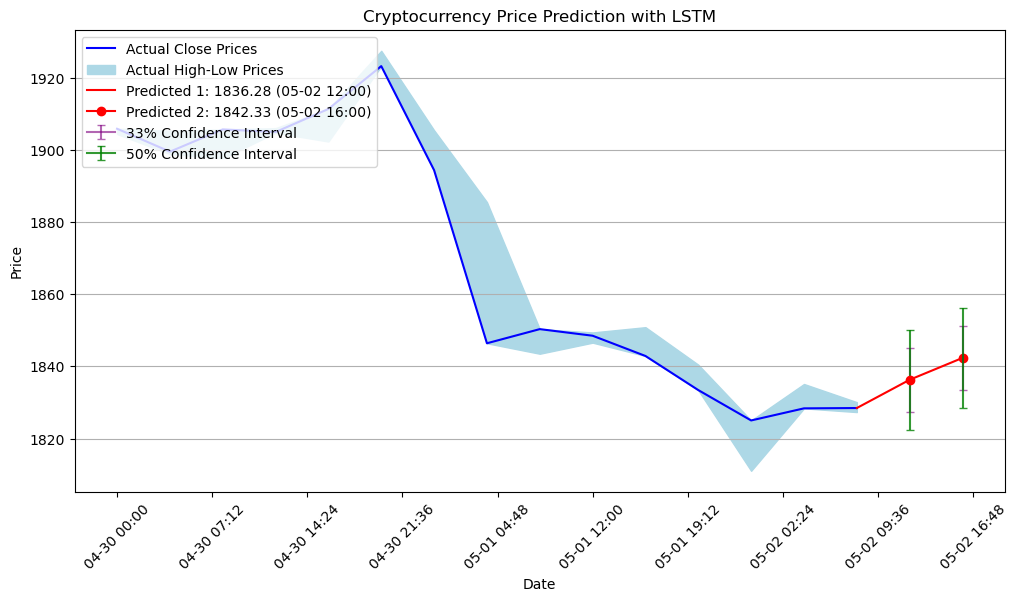

In [29]:
if __name__ == '__main__':
    ticker = input("Enter the cryptocurrency ticker (e.g., 'bitcoin' or 'ethereum'): ")
    interval = int(input("Enter the desired interval (1 for 1 hour, 4 for 4 hours, or 24 for 1 day): "))
    lookback_values = range(1, 3)
    n_future = 2
    main(ticker, lookback_values, n_future, interval)